**На этот раз ситуация следующая:** вы работаете в приложении по доставке готовых продуктов. К вам пришел коллега с результатами двух тестов:
- В первом тестировали разрешение фотографий блюд в приложении: пользователям показывались либо прямоугольные, либо новые квадратные 
- Во втором: была обновлена кнопка заказа, и часть юзеров видела старый вариант, а часть – новый

**Коллега пришел к вам с просьбой:** он посмотрел на графики и предположил, что среди групп могут встретиться различия. 

*Ваша задача – помочь ему проверить гипотезы, сделать соответствующие выводы на основе статистических тестов и принять решения.*

| Exp1,Exp2           | Описание                                                                               |
|---------------------|----------------------------------------------------------------------------------------|
| id                  | id клиента в эксперементе                                                    |
| group     | в каком разрешении показывались картинки(A-прямоугольные, 16,9. B - квадратные. С - прямоугольные 12.4)                                     |
| events      |events - сколько блюд суммарно было заказано за период                                                      |
| argument(exp2)                  | сегмент(high/low)                                                    |

In [125]:
#exp1
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg #лучше показывает

exp1 = pd.read_csv('F:\\карпов\\6 СТАТИСТИКА\\5 Anova\\5_task_1.csv')
exp2 = pd.read_csv('F:\\карпов\\6 СТАТИСТИКА\\5 Anova\\5_task_2.csv')
sns.set(rc={'figure.figsize': (16,6),'figure.dpi': (75)},style='darkgrid')

# сводная таблица
lst = []
for name in exp1.columns:
    nu = len(exp1[name].unique())
    nisnan = exp1[name].isnull().sum()
    values_sample = exp1[name].unique()[:min(nu,10)].tolist()
    lst.append([name,nu,nisnan, values_sample])
    
pd.DataFrame(lst,columns=['column','nunique','nnull','values'])

,column,nunique,nnull,values
0,id,30000,0,"[16046, 18712, 3268, 22633, 28071, 1794, 805, ..."
1,group,3,0,"[A, B, C]"
2,events,81,0,"[14, 41, 30, 37, 38, 34, 24, 20, 35, 28]"


In [126]:
# exp2
lst = []
for name in exp2.columns:
    nu = len(exp2[name].unique())
    nisnan = exp2[name].isnull().sum()
    values_sample = exp2[name].unique()[:min(nu,10)].tolist()
    lst.append([name,nu,nisnan, values_sample])
    
pd.DataFrame(lst,columns=['column','nunique','nnull','values'])

,column,nunique,nnull,values
0,id,100000,0,"[83440, 96723, 68719, 50399, 95613, 49481, 954..."
1,group,2,0,"[test, control]"
2,segment,2,0,"[high, low]"
3,events,97,0,"[78.0, 71.0, 80.0, 81.0, 57.0, 67.0, 73.0, 76...."


### Обзор

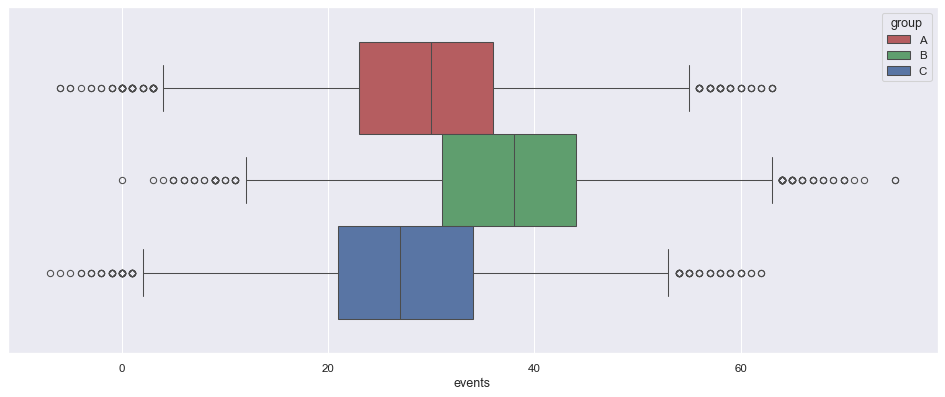

In [127]:
sns.boxplot(data=exp1, x = 'events', hue = 'group',palette=['r','g','b']);

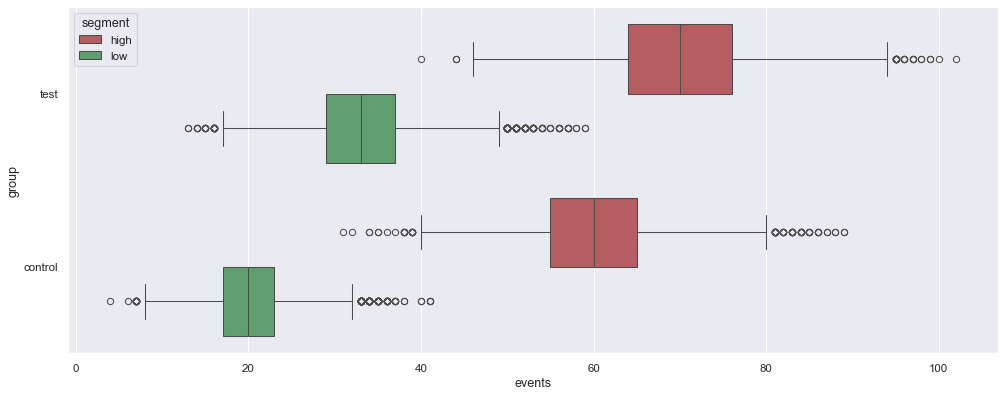

In [128]:
sns.boxplot(data=exp2, x = 'events', y = 'group', hue = 'segment',palette=['r','g']);

### 1. Выберите метод, который предположительно подойдет в первом вопросе.

Нужно проверить какой формат блюд является наилучшим, т.е. в какой из групп в среднем покупали больше всего. Всего пользователям показывали 3 варианта:
- A-прямоугольные - 16:9
- B - квадратные. 
- С - прямоугольные 12:4

Каким статистическим тестом нужно воспользоваться для сравнения средних в данном случае?
- 1. сделаю вывод искл. по графику
- 2. посчитаю хи-квадрат
- 3. ANOVA(верный)
- 4. t-test

### 2. Проверьте, являются ли дисперсии внутри групп гомогенными.

In [129]:
# критерий Левена 1 группа
# pval больше 0.05 не отклоняем нулевую гипотезу
pg.homoscedasticity(data=exp1,dv='events',group='group')

,W,pval,equal_var
levene,2.26226,0.104133,True


In [130]:
# критерий Левена 2 группа
pg.homoscedasticity(data=exp2,dv='events',group='group')

,W,pval,equal_var
levene,2.544005,0.110717,True


In [131]:
from scipy.stats import levene
gr1 = exp1.query('group == "A"').events
gr2 = exp1.query('group == "B"').events
gr3 = exp1.query('group == "C"').events

gr4 = exp2.query('group == "test"').events
gr5 = exp2.query('group == "control"').events

print('для exp1 сравниваем 3 группы по Бартлету')
levene(gr1,gr2,gr3)

для exp1 сравниваем 3 группы по Бартлету


LeveneResult(statistic=2.2622596339318037, pvalue=0.1041327199523974)

In [132]:
print('для exp2 сравниваем 2 группы по Бартлету')
levene(gr4,gr5)

для exp2 сравниваем 2 группы по Бартлету


LeveneResult(statistic=2.5440050816535327, pvalue=0.11071679229795423)

### 3. Проведите тест на нормальность распределения.

In [133]:
# через pinguin
pg.normality(data=exp1, dv='events',group='group', method='normaltest')

,W,pval,normal
group,,,
A,2.103460,0.349333,True
B,0.841072,0.656695,True
C,3.243726,0.197530,True


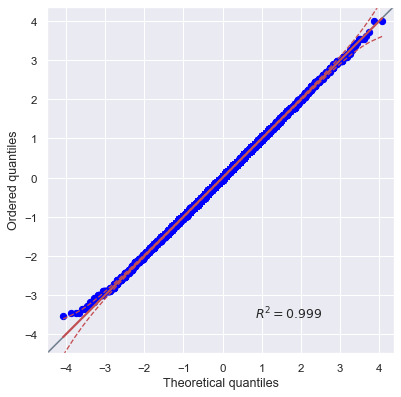

In [134]:
pg.qqplot(exp1.events);

### 4. Сравните Средние в представленных группах 

In [135]:
pg.anova(data=exp1, dv='events', between='group')

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,29997,2886.166657,0.0,0.161377


In [136]:
import scipy.stats as ss 
ss.f_oneway(gr1,gr2,gr3)

F_onewayResult(statistic=2886.166657438961, pvalue=0.0)

### 5. Используйте критерий Тьюки и определите, между какими группами есть статистически значимые различия.

In [137]:
#pval = 0 значит все стат значимые
pg.pairwise_tukey(data=exp1,dv='events',between='group')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140894,-57.021604,0.0,-0.806229
1,A,C,29.5796,27.4703,2.1093,0.140894,14.970833,0.0,0.210514
2,B,C,37.6136,27.4703,10.1433,0.140894,71.992436,0.0,1.024138


In [138]:
from statsmodels.stats.multicomp import MultiComparison

MultiComp = MultiComparison(exp1['events'], exp1['group'])
MultiComp.tukeyhsd().summary() 

group1,group2,meandiff,p-adj,lower,upper,reject
A,B,8.034,0.0,7.7038,8.3642,True
A,C,-2.1093,0.0,-2.4395,-1.7791,True
B,C,-10.1433,0.0,-10.4735,-9.8131,True


In [139]:
#учитывает не равенство дисперсий
pg.pairwise_gameshowell(data=exp1,dv='events',between='group')

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140920,-57.011134,19987.258491,6.412648e-13,-0.806229
1,A,C,29.5796,27.4703,2.1093,0.141696,14.886135,19995.116233,0.000000e+00,0.210514
2,B,C,37.6136,27.4703,10.1433,0.140062,72.420220,19995.502469,0.000000e+00,1.024138


In [140]:
# поправка на сравнение bonf - консервативная, строгая
pg.pairwise_tests(data=exp1,dv='events',between='group', padjust ='bonf')

C:\Users\Administrator\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pingouin\bayesian.py:152: RuntimeWarning: divide by zero encountered in scalar divide
  bf10 = 1 / ((1 + t**2 / df) ** (-(df + 1) / 2) / integr)
C:\Users\Administrator\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pingouin\bayesian.py:152: RuntimeWarning: divide by zero encountered in scalar divide
  bf10 = 1 / ((1 + t**2 / df) ** (-(df + 1) / 2) / integr)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,group,A,B,False,True,-57.011134,19998.0,two-sided,0.000000e+00,0.000000e+00,bonf,inf,-0.806229
1,group,A,C,False,True,14.886135,19998.0,two-sided,7.500262e-50,2.250078e-49,bonf,1.054e+46,0.210514
2,group,B,C,False,True,72.420220,19998.0,two-sided,0.000000e+00,0.000000e+00,bonf,inf,1.024138


### 6. Примите решение: какие картинки в итоге будем использовать?

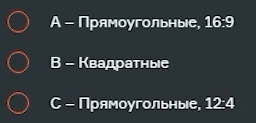

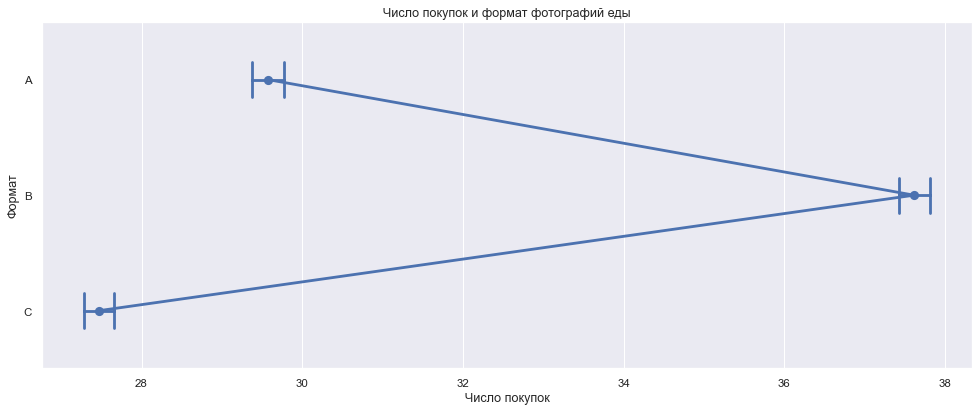

In [141]:
sns.pointplot(y = 'group', x = 'events', data= exp1, capsize = 0.3)
plt.title('Число покупок и формат фотографий еды')
plt.ylabel('Формат')
plt.xlabel('Число покупок');

### 7. Выберете метод для второго теста.

Во втором эксперименте требуется проверить, как пользователи отреагируют на изменение формата кнопки пользователи отреагиуют на изменение формата кнопки оформления заказа, с разбивкой по сегменту клиента.

Какой метод скорее всего пригодится в данном случае?
- t-test
- многофактовый дисперсионный анализ(да)
- однофакторвый дисперсионный анализ
- хи-квадрат

### 8. Визуализируйте распределение events для контрольной и тестовой групп.

А. 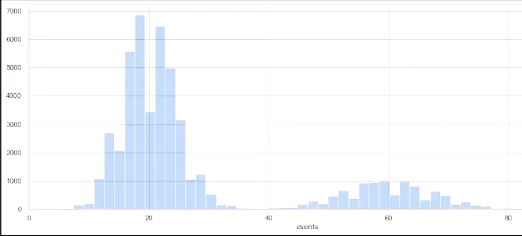

B. 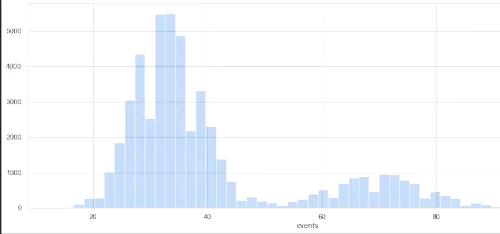

<Axes: xlabel='events', ylabel='Count'>

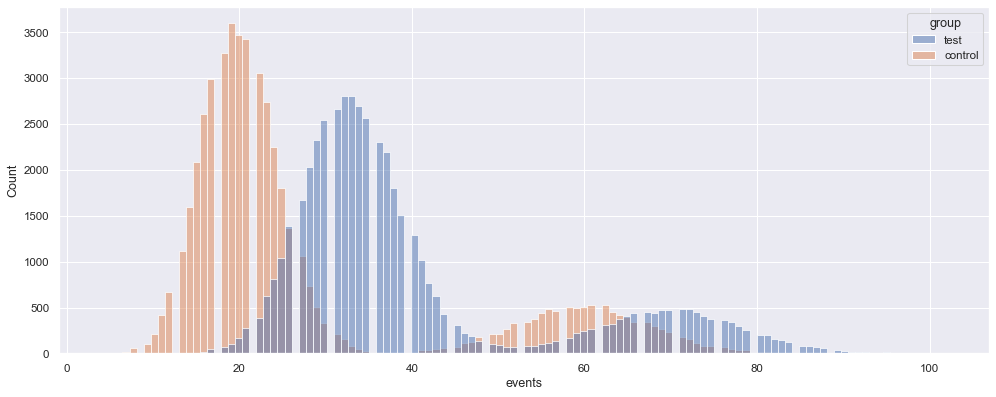

In [142]:
sns.histplot(data=exp2,x='events',hue='group')

### 9. Посмотрите на описательные статистики events в разбивке по группе и по сегрменту пользователя.

Посчитатйте среднее, медиану и стандартное отклонение events в разбивке по группе и по сегменту пользователя.

В качестве ответа укажите std для пользователей из сегмента high и контольой группы, с точность до 2 знаков после запятой.

In [143]:
exp2.groupby(['segment','group']).agg({'events':['mean','median','std']}).reset_index().round(2)

segment    group events             
                     mean median   std
0    high  control  59.97   60.0  7.81
1    high     test  69.94   70.0  8.40
2     low  control  20.03   20.0  4.47
3     low     test  33.03   33.0  5.72

In [144]:
exp2.groupby(['group', 'segment'])['events'].describe()[['mean', '50%', 'std']].round(2)

mean   50%   std
group   segment                   
control high     59.97  60.0  7.81
        low      20.03  20.0  4.47
test    high     69.94  70.0  8.40
        low      33.03  33.0  5.72

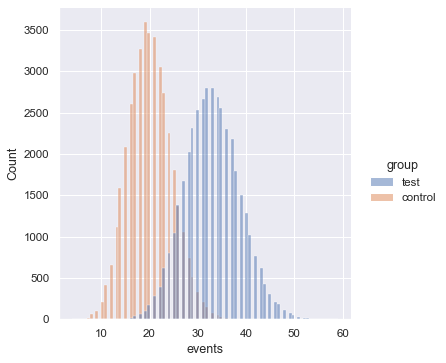

In [145]:
sns.displot(exp2.query('segment == "low"'), x='events', hue='group');

### 10-11. Выберете формулу для модели, проведите тест.

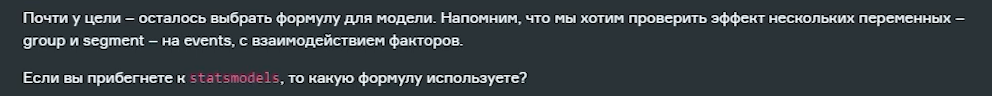

Надо проверить эффект нескольких переменных - group и segment - на events, с взаимодействием факторов.

Если исп statsmodels то какую формулу использовать?

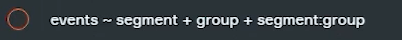

In [147]:
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm
model = smf.ols('events ~ C(segment) * C(group)',data=exp2).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
C(segment),1.0,2.362480e+07,2.362480e+07,689756.377484,0.000000e+00
C(group),1.0,3.837195e+06,3.837195e+06,112031.864119,0.000000e+00
C(segment):C(group),1.0,3.664244e+04,3.664244e+04,1069.823273,2.060261e-233
Residual,99996.0,3.424956e+06,3.425093e+01,NaN,NaN


In [148]:
pg.anova(data=exp2,dv='events',between=['group','segment'])

,Source,SS,DF,MS,F,p-unc,np2
0,group,3.837195e+06,1.0,3.837195e+06,112031.864119,0.000000e+00,0.528383
1,segment,2.362480e+07,1.0,2.362480e+07,689756.377484,0.000000e+00,0.873383
2,group * segment,3.664244e+04,1.0,3.664244e+04,1069.823273,2.060261e-233,0.010585
3,Residual,3.424956e+06,99996.0,3.425093e+01,NaN,NaN,NaN


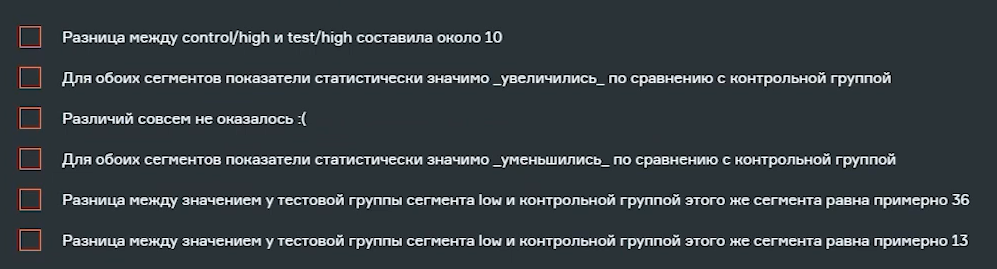

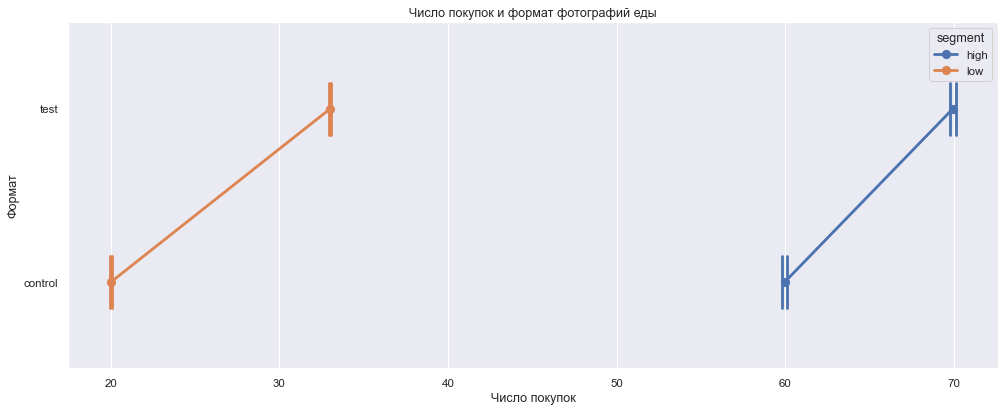

In [150]:
sns.pointplot(y = 'group', x = 'events', data= exp2,hue='segment', capsize = 0.3)
plt.title('Число покупок и формат фотографий еды')
plt.ylabel('Формат')
plt.xlabel('Число покупок');

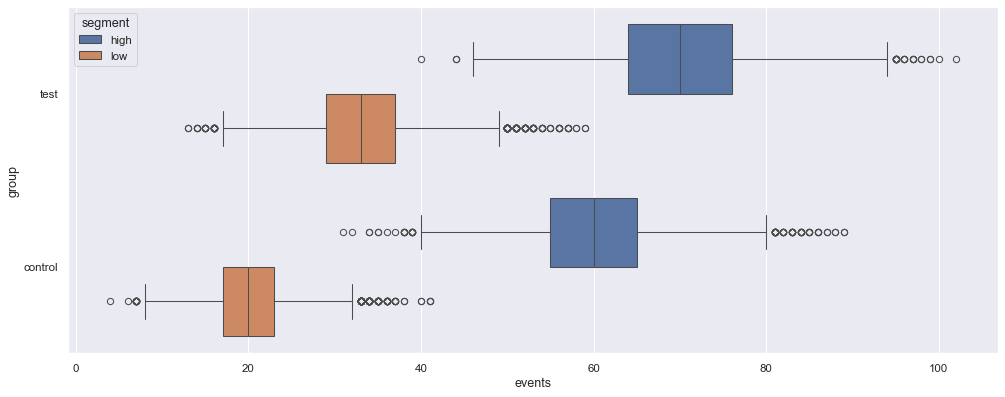

In [154]:
sns.boxplot(data=exp2,x='events', y = 'group',hue='segment');

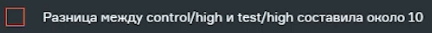




In [159]:
exp2['combination'] = exp2.group + '\\' + exp2.segment
exp2['combination'].head(3)

0    test\high
1    test\high
2    test\high
Name: combination, dtype: object

In [160]:
pg.pairwise_tukey(data=exp2, dv='events',between=['combination'])

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,control\high,control\low,59.970800,20.031575,39.939225,0.065432,610.391461,1.010172e-10,7.521612
1,control\high,test\high,59.970800,69.938500,-9.967700,0.082766,-120.432523,1.010172e-10,-1.228989
2,control\high,test\low,59.970800,33.025925,26.944875,0.065432,411.798717,1.010172e-10,4.350026
3,control\low,test\high,20.031575,69.938500,-49.906925,0.065432,-762.727892,1.010172e-10,-9.091140
4,control\low,test\low,20.031575,33.025925,-12.994350,0.041383,-314.002699,1.010172e-10,-2.530414
5,test\high,test\low,69.938500,33.025925,36.912575,0.065432,564.135148,1.010172e-10,5.814008


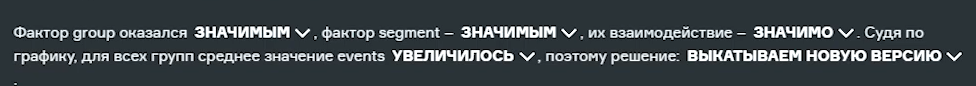